In [1]:
'''
Neoclassical Growth model

Finite difference method adapted from https://benjaminmoll.com/codes/ HJB_NGM.m
'''
import os
import time
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from deep_macrofin import (Comparator, OptimizerType, PDEModel,
                           PDEModelTimeStep, set_seeds)


plt.rcParams["font.size"] = 20
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["lines.markersize"] = 10

In [2]:
def utility(c, gamma):
    if gamma == 1:
        return np.log(c)
    else:
        return c**(1-gamma)/(1-gamma)

def utility_deriv(c, gamma):
    if gamma == 1:
        return 1 / c
    else:
        return c**(-gamma)

def inverse_marginal_deriv(dV, gamma):
    if gamma == 1:
        return 1 / dV
    else:
        return dV**(-1/gamma)

def solve_upwind(gamma, alpha, delta, rho, A, N, max_iter=10000, crit=1e-6):
    '''
    Inputs:
    - gamma: risk aversion
    - alpha: capital share
    - delta: depreciation
    - rho: discount rate
    - A: productivity
    - N: grid count
    - max_iter: maximum number of iterations
    - crit: error threshold
    '''
    kss = (alpha * A / (rho + delta)) ** (1 / (1-alpha))
    print(kss)
    kmin = 0.001 * kss
    kmax = 2 * kss
    k = np.linspace(kmin, kmax, N)
    dk = (kmax - kmin) / (N - 1)

    dVf = np.zeros(N)
    dVb = np.zeros(N)
    c = np.zeros(N)

    # Initial guess
    c0 = A * k ** alpha
    v0 = utility(c0, gamma) / rho
    v = v0.copy()

    dist = np.zeros(max_iter)
    for n in range(max_iter):
        V = v.copy()

        # Forward difference
        dVf[:-1] = (V[1:] - V[:-1]) / dk
        dVf[-1] = 0  # Never used

        # Backward difference
        dVb[1:] = (V[1:] - V[:-1]) / dk
        dVb[0] = 0  # Never used

        I_concave = dVb > dVf

        # Consumption and savings
        cf = inverse_marginal_deriv(dVf, gamma)
        muf = A * k ** alpha - delta * k - cf

        cb = inverse_marginal_deriv(dVb, gamma)
        mub = A * k ** alpha - delta * k - cb

        c0 = A * k ** alpha - delta * k
        dV0 = c0 ** (-gamma)

        # Upwind scheme
        If = muf > 0
        Ib = mub < 0
        I0 = ~(If | Ib)

        Ib[0] = False
        If[0] = True
        Ib[-1] = True
        If[-1] = False

        dV_Upwind = dVf * If + dVb * Ib + dV0 * I0

        c = inverse_marginal_deriv(dV_Upwind, gamma)
        Vchange = utility(c, gamma) + dV_Upwind * (A * k ** alpha - delta * k - c) - rho * V

        # Update
        DeltaT = 0.9 * dk / np.max(A * k ** alpha - delta * k)
        v += DeltaT * Vchange

        dist[n] = np.max(np.abs(Vchange))
        if dist[n] < crit:
            print(f'Value Function Converged, Iteration = {n}')
            break
    return k, v, c

In [3]:
def get_model(params: Dict[str, float], training_config: Dict[str, Dict], model_configs: Dict[str, Dict], seed=0, init_guess={"V": -18, "c": 1.5}):
    kss = (params["alpha"] / (params["rho"] + params["delta"])) ** (1 / (1 - params["alpha"]))
    ckss = kss**params["alpha"] - params["delta"] * kss
    set_seeds(seed)
    model = PDEModelTimeStep("ncg", config=training_config)
    model.set_state(["k"], {"k": [0.01 * kss, 2 * kss]}) #  
    model.add_params(params)
    model.add_endog("V", config=model_configs["V"])
    model.add_endog("c", config=model_configs["c"])
    if params["gamma"] == 1:
        endog_cond = torch.log(torch.tensor(ckss, dtype=torch.float32, device=model.device))/params["rho"]
        utility_eq = "u=log(c)"
    else:
        endog_cond = ckss**(1-params["gamma"]) / ((1-params["gamma"]) * params["rho"])
        utility_eq = "u=c**(1-gamma)/(1-gamma)"
    
    ss_bd = torch.zeros((100, 2), device=model.device)
    ss_bd[:, 0] = kss
    ss_bd[:, 1] = torch.linspace(0, 1, 100, device=model.device)
    model.add_endog_condition("V", 
                                "V(SV)", 
                                {"SV": ss_bd},
                                Comparator.EQ,
                                "ec", {"ec": endog_cond},
                                label="v1")
    model.add_endog_condition("c", 
                                "c(SV)", 
                                {"SV": ss_bd},
                                Comparator.EQ,
                                "kss**alpha - delta * kss", params | {"kss": kss},
                                label="c1")
    model.add_equation("s=k**alpha - delta * k - c")
    model.add_equation(utility_eq)
    model.add_endog_equation("c**(-gamma)=V_k")
    model.add_constraint("c_k", Comparator.GEQ, "0")
    model.add_hjb_equation("V_t + u+ V_k * s-rho*V")
    model.set_initial_guess(init_guess)
    return model

In [4]:
PARAMS = {
        "gamma": 2, # Risk aversion
        "alpha": 0.3, # Returns to scale
        "delta": 0.05, # Capital depreciation
        "rho": 0.05, # Discount rate
        "A": 1, # Productivity
    }
kss = (PARAMS["alpha"] / (PARAMS["rho"] + PARAMS["delta"])) ** (1 / (1 - PARAMS["alpha"]))

TRAINING_CONFIGS = {"num_outer_iterations": 20, "num_inner_iterations": 3000,  
        "time_batch_size": 4, "optimizer_type": OptimizerType.Adam}

MODEL_CONFIGS = {
    "V": {"hidden_units": [64] * 4},
    "c": {"hidden_units": [32] * 4, "positive": True},
}

INIT_GUESSES = {"V": -18, "c": 1.5}

BASE_DIR = "models/ncg_ts/"
os.makedirs(BASE_DIR, exist_ok=True)
print("{0:=^80}".format("loading FD solutions"))
if not os.path.exists(f"{BASE_DIR}/ncg_fd.npz"):
    k, v, c = solve_upwind(PARAMS["gamma"], PARAMS["alpha"], PARAMS["delta"], 
                        PARAMS["rho"], PARAMS["A"], 100)
    np.savez(f"{BASE_DIR}/ncg_fd.npz", k=k, v=v, c=c)
fd_res = np.load(f"{BASE_DIR}/ncg_fd.npz")

==============================loading FD solutions==============================


In [5]:
model = get_model(PARAMS, TRAINING_CONFIGS, MODEL_CONFIGS, 0)
if not os.path.exists(f"{BASE_DIR}/model.pt"):
    model.train_model(BASE_DIR, f"model.pt", True)
    model.eval_model(True)
else:
    model.load_model(torch.load(f"{BASE_DIR}/model.pt", weights_only=False, map_location=model.device))
    model.eval_model(True)

d:\Research\continuous-time-eco-models\venv\Lib\site-packages\torch\autograd\graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


====================================Training====================================


Min loss: 5.6676: 100%|██████████| 3000/3000 [01:40<00:00, 29.81it/s]


Model loaded
V: Mean Value: -16.34051, Absolute Change: 1.65949, Relative Change:  0.09219
c: Mean Value: 1.82914, Absolute Change: 0.33001, Relative Change:  0.22001
Updating min loss from inf to 5.6676
Outer Loop 0 Finished in 100.6457s. Loading best model...


Min loss: 0.3749: 100%|██████████| 2121/2121 [00:58<00:00, 36.21it/s]


Model loaded
V: Mean Value: -15.59404, Absolute Change: 0.80565, Relative Change:  0.04930
c: Mean Value: 3.42522, Absolute Change: 1.84181, Relative Change:  0.95252
Updating min loss from 5.6676 to 0.3768
Outer Loop 1 Finished in 58.5804s. Loading best model...


Min loss: 0.0361: 100%|██████████| 1732/1732 [00:50<00:00, 34.16it/s]


Model loaded
V: Mean Value: -15.15844, Absolute Change: 0.49918, Relative Change:  0.03244
c: Mean Value: 3.42685, Absolute Change: 0.35277, Relative Change:  0.10873
Updating min loss from 0.3768 to 0.0360
Outer Loop 2 Finished in 50.7120s. Loading best model...


Min loss: 0.0069: 100%|██████████| 1500/1500 [00:43<00:00, 34.63it/s]


Model loaded
V: Mean Value: -15.09124, Absolute Change: 0.13214, Relative Change:  0.00884
c: Mean Value: 3.24077, Absolute Change: 0.21021, Relative Change:  0.06603
Updating min loss from 0.0360 to 0.0069
Outer Loop 3 Finished in 43.3212s. Loading best model...


Min loss: 0.0034: 100%|██████████| 1341/1341 [00:44<00:00, 29.83it/s]


Model loaded
V: Mean Value: -15.07318, Absolute Change: 0.09003, Relative Change:  0.00596
c: Mean Value: 3.04851, Absolute Change: 0.19226, Relative Change:  0.06929
Updating min loss from 0.0069 to 0.0034
Outer Loop 4 Finished in 44.9560s. Loading best model...


Min loss: 0.0027: 100%|██████████| 1224/1224 [00:40<00:00, 29.86it/s]


Model loaded
V: Mean Value: -15.07501, Absolute Change: 0.08833, Relative Change:  0.00575
c: Mean Value: 2.94838, Absolute Change: 0.10485, Relative Change:  0.05051
Updating min loss from 0.0034 to 0.0027
Outer Loop 5 Finished in 40.9907s. Loading best model...


Min loss: 0.0025: 100%|██████████| 1133/1133 [00:34<00:00, 33.02it/s]


Model loaded
V: Mean Value: -15.08321, Absolute Change: 0.08078, Relative Change:  0.00521
c: Mean Value: 2.79290, Absolute Change: 0.15632, Relative Change:  0.05862
Updating min loss from 0.0027 to 0.0025
Outer Loop 6 Finished in 34.3147s. Loading best model...


Min loss: 0.0025: 100%|██████████| 1060/1060 [00:32<00:00, 32.73it/s]


Model loaded
V: Mean Value: -15.10047, Absolute Change: 0.08603, Relative Change:  0.00545
c: Mean Value: 2.61061, Absolute Change: 0.18501, Relative Change:  0.05939
Outer Loop 7 Finished in 32.3896s. Loading best model...


Min loss: 0.0023: 100%|██████████| 1000/1000 [00:27<00:00, 36.11it/s]


Model loaded
V: Mean Value: -15.12478, Absolute Change: 0.07776, Relative Change:  0.00481
c: Mean Value: 2.35469, Absolute Change: 0.25660, Relative Change:  0.07452
Updating min loss from 0.0025 to 0.0023
Outer Loop 8 Finished in 27.6961s. Loading best model...


Min loss: 0.0015: 100%|██████████| 1000/1000 [00:27<00:00, 36.67it/s]


Model loaded
V: Mean Value: -15.13617, Absolute Change: 0.07497, Relative Change:  0.00470
c: Mean Value: 2.03877, Absolute Change: 0.31821, Relative Change:  0.08666
Updating min loss from 0.0023 to 0.0015
Outer Loop 9 Finished in 27.2814s. Loading best model...


Min loss: 0.0012: 100%|██████████| 1000/1000 [00:28<00:00, 35.61it/s]


Model loaded
V: Mean Value: -15.14081, Absolute Change: 0.07203, Relative Change:  0.00459
c: Mean Value: 1.70299, Absolute Change: 0.34087, Relative Change:  0.10150
Updating min loss from 0.0015 to 0.0012
Outer Loop 10 Finished in 28.0833s. Loading best model...


Min loss: 0.0005: 100%|██████████| 1000/1000 [00:30<00:00, 32.57it/s]


Model loaded
V: Mean Value: -15.13488, Absolute Change: 0.04740, Relative Change:  0.00315
c: Mean Value: 1.48093, Absolute Change: 0.22575, Relative Change:  0.08043
Updating min loss from 0.0012 to 0.0005
Outer Loop 11 Finished in 30.7074s. Loading best model...


Min loss: 0.0011: 100%|██████████| 1000/1000 [00:32<00:00, 30.52it/s]


Model loaded
V: Mean Value: -15.13747, Absolute Change: 0.03377, Relative Change:  0.00222
c: Mean Value: 1.38242, Absolute Change: 0.10730, Relative Change:  0.04921
Outer Loop 12 Finished in 32.7731s. Loading best model...


Min loss: 0.0012: 100%|██████████| 1000/1000 [00:31<00:00, 31.73it/s]


Model loaded
V: Mean Value: -15.14240, Absolute Change: 0.01897, Relative Change:  0.00126
c: Mean Value: 1.34380, Absolute Change: 0.04542, Relative Change:  0.02465
Outer Loop 13 Finished in 31.5228s. Loading best model...


Min loss: 0.0002: 100%|██████████| 1000/1000 [00:28<00:00, 34.78it/s]


Model loaded
V: Mean Value: -15.15127, Absolute Change: 0.01412, Relative Change:  0.00088
c: Mean Value: 1.32487, Absolute Change: 0.02317, Relative Change:  0.01524
Updating min loss from 0.0005 to 0.0002
Outer Loop 14 Finished in 28.7524s. Loading best model...


Min loss: 0.0004: 100%|██████████| 1000/1000 [00:28<00:00, 34.62it/s]


Model loaded
V: Mean Value: -15.15927, Absolute Change: 0.01053, Relative Change:  0.00065
c: Mean Value: 1.31010, Absolute Change: 0.01910, Relative Change:  0.01307
Outer Loop 15 Finished in 28.8896s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1000/1000 [00:28<00:00, 35.66it/s]


Model loaded
V: Mean Value: -15.16779, Absolute Change: 0.00954, Relative Change:  0.00057
c: Mean Value: 1.30611, Absolute Change: 0.00993, Relative Change:  0.00890
Updating min loss from 0.0002 to 0.0001
Outer Loop 16 Finished in 28.0506s. Loading best model...


Min loss: 0.0000: 100%|██████████| 1000/1000 [00:26<00:00, 38.05it/s]


Model loaded
V: Mean Value: -15.17639, Absolute Change: 0.00945, Relative Change:  0.00056
c: Mean Value: 1.30146, Absolute Change: 0.00813, Relative Change:  0.00628
Updating min loss from 0.0001 to 0.0000
Outer Loop 17 Finished in 26.2828s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1000/1000 [00:28<00:00, 35.27it/s]


Model loaded
V: Mean Value: -15.18361, Absolute Change: 0.00812, Relative Change:  0.00049
c: Mean Value: 1.30115, Absolute Change: 0.00507, Relative Change:  0.00475
Outer Loop 18 Finished in 28.3500s. Loading best model...


Min loss: 0.0000: 100%|██████████| 1000/1000 [00:31<00:00, 32.14it/s]


Model loaded
V: Mean Value: -15.18958, Absolute Change: 0.00639, Relative Change:  0.00041
c: Mean Value: 1.29949, Absolute Change: 0.00377, Relative Change:  0.00338
Updating min loss from 0.0000 to 0.0000
Outer Loop 19 Finished in 31.1145s. Loading best model...
training finished, total time :: 757.1031982898712
Best model saved to models/ncg_ts//model_best.pt if valid
Model saved to models/ncg_ts//model.pt
===================================Evaluating===================================
loss :: endogvar_V_cond_v1: 0.0000,
endogvar_c_cond_c1: 0.0000,
endogeq_1: 0.0000,
constraint_1: 0.0000,
hjbeq_1: 0.0000,
endogvar_V_cond_time_boundary: 0.0000,
endogvar_c_cond_time_boundary: 0.0000,
total_loss: 0.0001


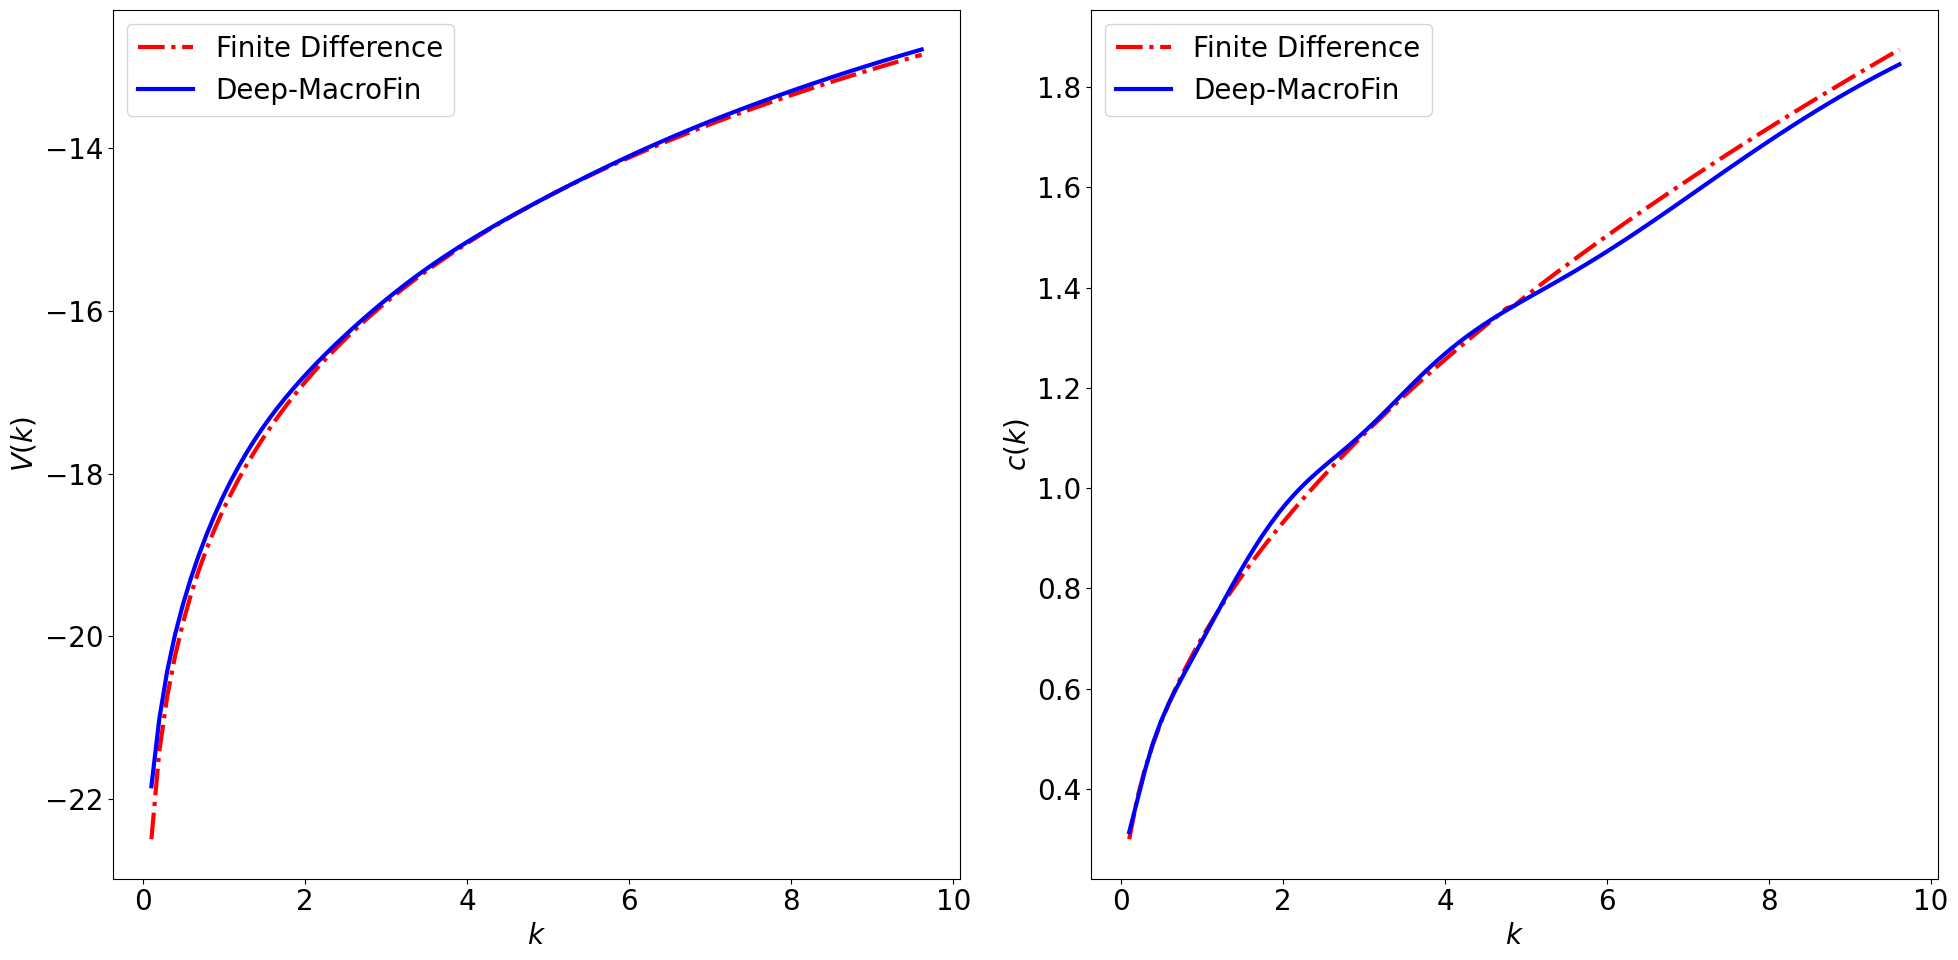

In [6]:
k_fd = fd_res["k"]
v_fd = fd_res["v"]
c_fd = fd_res["c"]
idx = k_fd > 0.01 * kss
k_fd = k_fd[idx]
v_fd = v_fd[idx]
c_fd = c_fd[idx]

SV = torch.zeros((k_fd.shape[0], 2), device=model.device)
SV[:, 0] = torch.tensor(k_fd, device=model.device, dtype=torch.float32)
for i, sv_name in enumerate(model.state_variables):
    model.variable_val_dict[sv_name] = SV[:, i:i+1]
model.variable_val_dict["SV"] = SV
model.update_variables(SV)
V_model = model.variable_val_dict["V"].detach().cpu().numpy().reshape(-1)
c_model = model.variable_val_dict["c"].detach().cpu().numpy().reshape(-1)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(k_fd, v_fd, linestyle="-.", color="red", label="Finite Difference")
ax[0].plot(k_fd, V_model, color="blue", label=f"Deep-MacroFin")
ax[0].legend()
ax[0].set_xlabel("$k$")
ax[0].set_ylabel("$V(k)$")

ax[1].plot(k_fd, c_fd, linestyle="-.", color="red", label="Finite Difference")
ax[1].plot(k_fd, c_model, color="blue", label=f"Deep-MacroFin")
ax[1].legend()
ax[1].set_xlabel("$k$")
ax[1].set_ylabel("$c(k)$")
plt.tight_layout()
plt.show()